# 02 — LinkedIn Lead Scoring: Model Training

**Purpose**: Train and evaluate classification models to predict LinkedIn engagement.

**MLflow Integration**: All models, hyperparameters, and metrics tracked from the start.

**Workflow**:
1. Setup MLflow experiment
2. Load cleaned dataset
3. Feature engineering
4. Train-test split
5. Handle class imbalance
6. Train baseline models
7. Train tree-based models
8. Hyperparameter tuning (Optuna)
9. Model explainability (SHAP)
10. Model selection & registration

**Output**: Best model registered in MLflow Model Registry

## 0. Setup & Imports

In [1]:
# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import warnings
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Imbalance handling (DISABLED - compatibility issue with scikit-learn 1.5+)
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.combine import SMOTETomek
# WORKAROUND: Using class_weight='balanced' in models instead

# Hyperparameter tuning
import optuna
from optuna.integration.mlflow import MLflowCallback

# Explainability
import shap

# MLflow setup
from linkedin_lead_scoring.data.utils_data import setup_mlflow

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✓ Imports complete")
print("⚠️  Note: imbalanced-learn disabled (compatibility issue)")

/opt/anaconda3/envs/OC6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports complete
⚠️  Note: imbalanced-learn disabled (compatibility issue)


## 1. MLflow Experiment Setup

**CRITICAL**: Initialize MLflow before any model training!

In [2]:
# Initialize MLflow experiment (auto-configures tracking to project root)
experiment_id = setup_mlflow(experiment_name="linkedin-lead-scoring")

# Start a run for model training
mlflow.start_run(run_name="model_training_session")

# Log notebook metadata
mlflow.log_param("notebook", "02_linkedin_model_training.ipynb")
mlflow.log_param("purpose", "model_training")
mlflow.log_param("author", "Ghislain de Labie")

print(f"✓ MLflow run started: {mlflow.active_run().info.run_id}")
print(f"✓ View results: http://localhost:5000")

✓ MLflow tracking configured
  Project root: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring
  Tracking URI: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns
✓ MLflow experiment: 'linkedin-lead-scoring'
  Experiment ID: 796258469850849262
  Artifact location: file:///Users/ghislaindelabie/Projets%20de%CC%81v/Formation%20OC/OC6%20-%20Initiez-vous%20au%20MLOps/oc6-linkedin-lead-scoring/mlruns/796258469850849262
✓ MLflow run started: b7989e9ca44a45f9bd17c52356436579
✓ View results: http://localhost:5000


## 2. Load Cleaned Dataset

In [10]:
# Load cleaned dataset from notebook 01
data_path = "../data/processed/linkedin_leads_clean.csv"
df = pd.read_csv(data_path)

print(f"✓ Loaded {len(df):,} rows × {len(df.columns)} columns")
print(f"\nTarget distribution:")
print(df['engaged'].value_counts())
print(f"Positive rate: {df['engaged'].mean():.1%}")

# Log to MLflow
mlflow.log_param("data_source", data_path)
mlflow.log_metric("n_samples_total", len(df))
mlflow.log_metric("n_features_raw", len(df.columns) - 1)  # Exclude target
mlflow.log_metric("positive_rate_full_dataset", df['engaged'].mean())

df.head()

✓ Loaded 303 rows × 20 columns

Target distribution:
engaged
0    182
1    121
Name: count, dtype: int64
Positive rate: 39.9%


,timezone,companyname,companydomain,icebreaker,location,tagline,industry,summary,languages,skills,jobtitle,companydescription,companyfoundedon,companyindustry,companylocation,companysize,companyspecialties,companytagline,companytype,engaged
0,NaN,Slack,slack.com,NaN,"Paris, Île-de-France, France",Lead Solutions Engineer @Slack,Information Technology & Services,Experienced Sales Engineer (18+ years) with a ...,"Arabic, English, French","Vente aux dirigeants, Relations avec les dirig...",Lead Solutions Engineer,Slack is on a mission to make people's working...,NaN,Software Development,"San Francisco, US",1001-5000,NaN,NaN,Public Company,1
1,NaN,Mistral AI,mistral.ai,NaN,"Paris, Île-de-France, France","Director, Commercial legal affairs @Mistral AI",Computer Software,NaN,"Anglais, Espagnol, Français","Droit commercial, Rédaction de contrats, Droit...","Director, Commercial legal affairs",Frontier AI. In your hands. \n\nWe believe in ...,2023.0,Software Development,"Paris, FR",201-500,NaN,Frontier AI. In Your Hands.,Privately Held,0
2,NaN,NaN,NaN,NaN,"Paris, Île-de-France, France",Growth & Ops,Information Technology & Services,NaN,"Allemand, Anglais, Français","Growth Hacking, Automatisation marketing, Sale...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,NaN,Nova Consulting,nova-consulting.eu,NaN,"Paris, Île-de-France, France",Chief Data&AI Officer @Nova Consulting,Higher Education,NaN,"Arabic, Chinese, English, French, Hebrew","Research and Development (R&D), Large Language...",Chief Data & AI Officer,[Nous recrutons : https://www.nova-consulting....,2006.0,Business Consulting and Services,"Paris, FR",51-200,"Conseil en stratégie, Conseil dans le domaine ...",Transformer l'irrationnel en rentabilité,Partnership,1
4,NaN,MongoDB,mongodb.com,NaN,"Paris, Île-de-France, France",Technology Executive in Enterprise Software | ...,Information Technology & Services,🚀 Technology & Business Leader | Digital Trans...,"English, French","Strategic Partnerships & Partner Enablement, D...",Global Head Cloud Partner Solutions Architect,"Headquartered in New York, MongoDB's mission i...",2007.0,Software Development,"New York, US",5001-10000,"open source, databases, mongodb, software deve...",Think outside rows and columns.,Public Company,0


## 3. Feature Engineering

**Basic encoding for categorical features**

In [11]:
# Separate features and target
X = df.drop(columns=['engaged'])
y = df['engaged']

print(f"Initial shape: {X.shape}")
print(f"Target shape: {y.shape}")

# ============================================================================
# STEP 1: Remove columns with too many missing values (>80%)
# ============================================================================
missing_pct = (X.isnull().sum() / len(X)) * 100
high_missing_cols = missing_pct[missing_pct > 80].index.tolist()

if high_missing_cols:
    print(f"\n⚠️  Dropping {len(high_missing_cols)} columns with >80% missing:")
    for col in high_missing_cols:
        print(f"   - {col}: {missing_pct[col]:.1f}% missing")
    X = X.drop(columns=high_missing_cols)

# ============================================================================
# STEP 2: Remove constant columns (same value for all rows)
# ============================================================================
constant_cols = []
for col in X.columns:
    if X[col].nunique() <= 1:
        constant_cols.append(col)

if constant_cols:
    print(f"\n⚠️  Dropping {len(constant_cols)} constant columns:")
    for col in constant_cols:
        print(f"   - {col}")
    X = X.drop(columns=constant_cols)

print(f"\n✓ After cleanup: {X.shape}")

# ============================================================================
# STEP 3: Identify numeric and categorical columns
# ============================================================================
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nFeature types:")
print(f"  Numeric: {len(numeric_cols)}")
print(f"  Categorical: {len(categorical_cols)}")

# ============================================================================
# STEP 4: Smart imputation based on data type
# ============================================================================
print(f"\nHandling missing values...")

# For numeric: use median (robust to outliers)
for col in numeric_cols:
    missing = X[col].isnull().sum()
    if missing > 0:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        print(f"  ✓ {col}: filled {missing} missing with median ({median_val})")

# For categorical: use mode (most frequent), or 'unknown' if empty
for col in categorical_cols:
    missing = X[col].isnull().sum()
    if missing > 0:
        mode_val = X[col].mode()
        if len(mode_val) > 0:
            X[col].fillna(mode_val[0], inplace=True)
            print(f"  ✓ {col}: filled {missing} missing with mode ('{mode_val[0]}')")
        else:
            X[col].fillna('unknown', inplace=True)
            print(f"  ✓ {col}: filled {missing} missing with 'unknown'")

# Verify no missing values remain
remaining_missing = X.isnull().sum().sum()
if remaining_missing > 0:
    print(f"\n⚠️  WARNING: {remaining_missing} missing values still remain!")
else:
    print(f"\n✓ All missing values handled")

# ============================================================================
# STEP 5: Encode categorical features
# ============================================================================
print(f"\nEncoding categorical features...")

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    # Only encode if column still exists and has data
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ {col}: {X[col].nunique()} unique values → encoded")

print(f"\n✓ Feature engineering complete")
print(f"  Final shape: {X_encoded.shape}")
print(f"  Features: {list(X_encoded.columns)}")

# ============================================================================
# Log to MLflow
# ============================================================================
mlflow.log_param("n_features_after_cleanup", X_encoded.shape[1])
mlflow.log_param("n_numeric_features", len(numeric_cols))
mlflow.log_param("n_categorical_features", len(categorical_cols))
mlflow.log_param("n_dropped_high_missing", len(high_missing_cols))
mlflow.log_param("n_dropped_constant", len(constant_cols))
mlflow.log_param("encoding_method", "label_encoding")
mlflow.log_param("imputation_numeric", "median")
mlflow.log_param("imputation_categorical", "mode_or_unknown")

Initial shape: (303, 19)
Target shape: (303,)

⚠️  Dropping 2 columns with >80% missing:
   - timezone: 100.0% missing
   - icebreaker: 100.0% missing

✓ After cleanup: (303, 17)

Feature types:
  Numeric: 1
  Categorical: 16

Handling missing values...
  ✓ companyfoundedon: filled 167 missing with median (2016.5)
  ✓ companyname: filled 45 missing with mode ('World Game')
  ✓ companydomain: filled 121 missing with mode ('world.game')
  ✓ tagline: filled 8 missing with mode ('#accessibility #believability #cybersecurity')
  ✓ industry: filled 8 missing with mode ('Computer Software')
  ✓ summary: filled 82 missing with mode (''- Public Affairs & Strategic Communication specialist, at both French and European levels 
- Designing, coordinating, implementing lobbying strategies to engage & influence decision-makers (public targets but also business partners as well as media)
- Supervising PA/PR outreach campaigns based on a business-oriented approach ("facts & figures")
-  Hybrid profile 

'mode_or_unknown'

## 4. Train-Test Split

**Stratified split to preserve class balance**

## 3b. Data Validation

**Verify data is ready for modeling**

In [12]:
# Final validation before training
print("="*60)
print("DATA VALIDATION")
print("="*60)

# Check 1: No missing values
missing_total = X_encoded.isnull().sum().sum()
print(f"\n✓ Missing values: {missing_total}")
if missing_total > 0:
    print("  ⚠️  WARNING: Data still has missing values!")
    print(X_encoded.isnull().sum()[X_encoded.isnull().sum() > 0])
    raise ValueError("Data contains missing values - cannot proceed with training")

# Check 2: No infinite values
inf_total = np.isinf(X_encoded.select_dtypes(include=[np.number])).sum().sum()
print(f"✓ Infinite values: {inf_total}")
if inf_total > 0:
    print("  ⚠️  WARNING: Data has infinite values!")
    raise ValueError("Data contains infinite values - cannot proceed with training")

# Check 3: All features are numeric
non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"✓ All features numeric: {len(non_numeric) == 0}")
if non_numeric:
    print(f"  ⚠️  WARNING: Non-numeric columns found: {non_numeric}")
    raise ValueError("All features must be numeric after encoding")

# Check 4: Feature variability (no constant features)
constant_features = []
for col in X_encoded.columns:
    if X_encoded[col].nunique() == 1:
        constant_features.append(col)

print(f"✓ Constant features: {len(constant_features)}")
if constant_features:
    print(f"  ⚠️  WARNING: Constant features found: {constant_features}")
    X_encoded = X_encoded.drop(columns=constant_features)
    print(f"  → Dropped {len(constant_features)} constant features")

# Check 5: Target variable
print(f"\n✓ Target distribution:")
print(f"  Class 0: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Class 1: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

print(f"\n{'='*60}")
print(f"✅ DATA READY FOR TRAINING")
print(f"{'='*60}")
print(f"Final features: {X_encoded.shape[1]}")
print(f"Total samples: {len(X_encoded)}")
print(f"{'='*60}\n")

DATA VALIDATION

✓ Missing values: 0
✓ Infinite values: 0
✓ All features numeric: True
✓ Constant features: 0

✓ Target distribution:
  Class 0: 182 (60.1%)
  Class 1: 121 (39.9%)

✅ DATA READY FOR TRAINING
Final features: 17
Total samples: 303



In [13]:
# Split data (80/20 split, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"✓ Train-test split complete")
print(f"  Train: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_encoded):.1%})")
print(f"  Test:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X_encoded):.1%})")
print(f"\nClass balance:")
print(f"  Train positive rate: {y_train.mean():.1%}")
print(f"  Test positive rate:  {y_test.mean():.1%}")

# Scale numeric features (important for some models)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if len(numeric_cols) > 0:
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    print(f"\n✓ Scaled {len(numeric_cols)} numeric features")

# Log to MLflow
mlflow.log_param("test_size", 0.2)
mlflow.log_param("stratify", True)
mlflow.log_param("random_state", 42)
mlflow.log_metric("train_size", len(X_train))
mlflow.log_metric("test_size", len(X_test))
mlflow.log_metric("train_positive_rate", y_train.mean())
mlflow.log_metric("test_positive_rate", y_test.mean())

✓ Train-test split complete
  Train: 242 samples (79.9%)
  Test:  61 samples (20.1%)

Class balance:
  Train positive rate: 40.1%
  Test positive rate:  39.3%

✓ Scaled 1 numeric features


## 5. Class Imbalance Handling (Optional)

**Test different balancing strategies**

In [14]:
# Check current class balance
class_counts = y_train.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Class distribution in training set:")
print(class_counts)
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

# WORKAROUND: imbalanced-learn has compatibility issues
# Using class_weight='balanced' in models instead of SMOTE
print(f"\n✓ Using class_weight='balanced' in models (no SMOTE)")
print(f"  This adjusts model training to account for class imbalance")

X_train_balanced = X_train_scaled
y_train_balanced = y_train

# Log to MLflow
mlflow.log_param("balancing_method", "class_weight_balanced")
mlflow.log_metric("imbalance_ratio", imbalance_ratio)

print(f"\nNote: All tree-based models will use class_weight='balanced' parameter")

Class distribution in training set:
engaged
0    145
1     97
Name: count, dtype: int64
Imbalance ratio: 1.49

✓ Using class_weight='balanced' in models (no SMOTE)
  This adjusts model training to account for class imbalance

Note: All tree-based models will use class_weight='balanced' parameter


## 6. Model Evaluation Function

**Comprehensive evaluation with MLflow logging**

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, log_artifacts=True):
    """
    Comprehensive model evaluation with MLflow tracking.
    
    Parameters
    ----------
    model : sklearn-like estimator
        Fitted model to evaluate.
    X_train, X_test : pd.DataFrame
        Training and test features.
    y_train, y_test : pd.Series
        Training and test labels.
    model_name : str
        Name for logging and plots.
    log_artifacts : bool, default True
        Whether to log plots as artifacts.
    
    Returns
    -------
    dict
        Dictionary of evaluation metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Prediction probabilities
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_test_proba = y_test_pred
    
    # === Classification Metrics ===
    metrics = {
        # Train metrics
        "train_accuracy": accuracy_score(y_train, y_train_pred),
        "train_precision": precision_score(y_train, y_train_pred, zero_division=0),
        "train_recall": recall_score(y_train, y_train_pred, zero_division=0),
        "train_f1": f1_score(y_train, y_train_pred, zero_division=0),
        "train_roc_auc": roc_auc_score(y_train, y_train_proba),
        
        # Test metrics (most important!)
        "test_accuracy": accuracy_score(y_test, y_test_pred),
        "test_precision": precision_score(y_test, y_test_pred, zero_division=0),
        "test_recall": recall_score(y_test, y_test_pred, zero_division=0),
        "test_f1": f1_score(y_test, y_test_pred, zero_division=0),
        "test_roc_auc": roc_auc_score(y_test, y_test_proba),
        "test_avg_precision": average_precision_score(y_test, y_test_proba),
    }
    
    # Log all metrics to MLflow
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(metric_name, metric_value)
    
    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    mlflow.log_metric("test_true_negatives", int(tn))
    mlflow.log_metric("test_false_positives", int(fp))
    mlflow.log_metric("test_false_negatives", int(fn))
    mlflow.log_metric("test_true_positives", int(tp))
    
    if log_artifacts:
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {model_name}')
        fig.savefig('/tmp/confusion_matrix.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/confusion_matrix.png', 'evaluation')
        plt.close()
    
    # === ROC Curve ===
    if log_artifacts and hasattr(model, 'predict_proba'):
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, label=f'ROC (AUC = {metrics["test_roc_auc"]:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', label='Random')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {model_name}')
        ax.legend()
        ax.grid(True)
        fig.savefig('/tmp/roc_curve.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/roc_curve.png', 'evaluation')
        plt.close()
        
        # === Precision-Recall Curve ===
        precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(recall, precision, label=f'PR (AP = {metrics["test_avg_precision"]:.3f})')
        ax.axhline(y=y_test.mean(), color='k', linestyle='--', label='Baseline')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curve - {model_name}')
        ax.legend()
        ax.grid(True)
        fig.savefig('/tmp/pr_curve.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/pr_curve.png', 'evaluation')
        plt.close()
    
    # === Classification Report ===
    if log_artifacts:
        report = classification_report(y_test, y_test_pred)
        with open('/tmp/classification_report.txt', 'w') as f:
            f.write(report)
        mlflow.log_artifact('/tmp/classification_report.txt', 'evaluation')
    
    # === Feature Importance ===
    if log_artifacts and hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train.columns
        
        # Sort by importance
        indices = np.argsort(importances)[::-1][:20]  # Top 20
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.barh(range(len(indices)), importances[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'Top 20 Feature Importances - {model_name}')
        ax.invert_yaxis()
        fig.savefig('/tmp/feature_importance.png', dpi=100, bbox_inches='tight')
        mlflow.log_artifact('/tmp/feature_importance.png', 'evaluation')
        plt.close()
        
        # Log top features as parameters
        top_5_features = [feature_names[i] for i in indices[:5]]
        mlflow.log_param("top_5_features", ",".join(top_5_features))
    
    print(f"✓ Evaluation complete for {model_name}")
    print(f"  Test Accuracy:  {metrics['test_accuracy']:.3f}")
    print(f"  Test Precision: {metrics['test_precision']:.3f}")
    print(f"  Test Recall:    {metrics['test_recall']:.3f}")
    print(f"  Test F1:        {metrics['test_f1']:.3f}")
    print(f"  Test ROC-AUC:   {metrics['test_roc_auc']:.3f}")
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


## 7. Baseline Models

**Establish performance baselines**

In [16]:
baseline_models = {
    "Dummy_Stratified": DummyClassifier(strategy="stratified", random_state=42),
    "Dummy_MostFrequent": DummyClassifier(strategy="most_frequent", random_state=42),
    "Logistic_Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
}

baseline_results = {}

print("Training baseline models...\n")

for model_name, model in baseline_models.items():
    print(f"{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    # End previous run if active
    if mlflow.active_run():
        mlflow.end_run()
    
    with mlflow.start_run(run_name=f"baseline_{model_name}"):
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("model_family", "baseline")
        mlflow.log_params(model.get_params())
        
        # Train
        model.fit(X_train_balanced, y_train_balanced)
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        # Evaluate
        metrics = evaluate_model(
            model, X_train_balanced, X_test_scaled, y_train_balanced, y_test,
            model_name, log_artifacts=True
        )
        baseline_results[model_name] = metrics
    
    print("\n")

print("✓ Baseline models complete")

2025/12/12 12:43:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training baseline models...

Training: Dummy_Stratified


2025/12/12 12:43:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Dummy_Stratified
  Test Accuracy:  0.590
  Test Precision: 0.476
  Test Recall:    0.417
  Test F1:        0.444
  Test ROC-AUC:   0.560


Training: Dummy_MostFrequent


2025/12/12 12:43:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for Dummy_MostFrequent
  Test Accuracy:  0.607
  Test Precision: 0.000
  Test Recall:    0.000
  Test F1:        0.000
  Test ROC-AUC:   0.500


Training: Logistic_Regression
✓ Evaluation complete for Logistic_Regression
  Test Accuracy:  0.541
  Test Precision: 0.400
  Test Recall:    0.333
  Test F1:        0.364
  Test ROC-AUC:   0.482


✓ Baseline models complete


## 8. Tree-Based Models

**Train ensemble models with default hyperparameters**

In [17]:
tree_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=1.5,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
}

tree_results = {}

print("Training tree-based models...\n")

for model_name, model in tree_models.items():
    print(f"{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    # End previous run if active
    if mlflow.active_run():
        mlflow.end_run()
    
    with mlflow.start_run(run_name=f"tree_{model_name}"):
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("model_family", "tree_based")
        mlflow.log_params(model.get_params())
        
        # Train
        model.fit(X_train_balanced, y_train_balanced)
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        # Evaluate
        metrics = evaluate_model(
            model, X_train_balanced, X_test_scaled, y_train_balanced, y_test,
            model_name, log_artifacts=True
        )
        tree_results[model_name] = metrics
    
    print("\n")

print("✓ Tree-based models complete")

2025/12/12 12:43:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Training tree-based models...

Training: RandomForest


2025/12/12 12:43:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for RandomForest
  Test Accuracy:  0.607
  Test Precision: 0.500
  Test Recall:    0.333
  Test F1:        0.400
  Test ROC-AUC:   0.532


Training: GradientBoosting
✓ Evaluation complete for GradientBoosting
  Test Accuracy:  0.590
  Test Precision: 0.474
  Test Recall:    0.375
  Test F1:        0.419
  Test ROC-AUC:   0.552


Training: XGBoost


2025/12/12 12:43:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Evaluation complete for XGBoost
  Test Accuracy:  0.607
  Test Precision: 0.500
  Test Recall:    0.542
  Test F1:        0.520
  Test ROC-AUC:   0.596


✓ Tree-based models complete


## 9. Model Comparison

**Compare all models trained so far**

Model Comparison (sorted by F1 score):
                     test_accuracy  test_precision  test_recall  test_f1  \
XGBoost                      0.607           0.500        0.542    0.520   
Dummy_Stratified             0.590           0.476        0.417    0.444   
GradientBoosting             0.590           0.474        0.375    0.419   
RandomForest                 0.607           0.500        0.333    0.400   
Logistic_Regression          0.541           0.400        0.333    0.364   
Dummy_MostFrequent           0.607           0.000        0.000    0.000   

                     test_roc_auc  
XGBoost                     0.596  
Dummy_Stratified            0.560  
GradientBoosting            0.552  
RandomForest                0.532  
Logistic_Regression         0.482  
Dummy_MostFrequent          0.500  


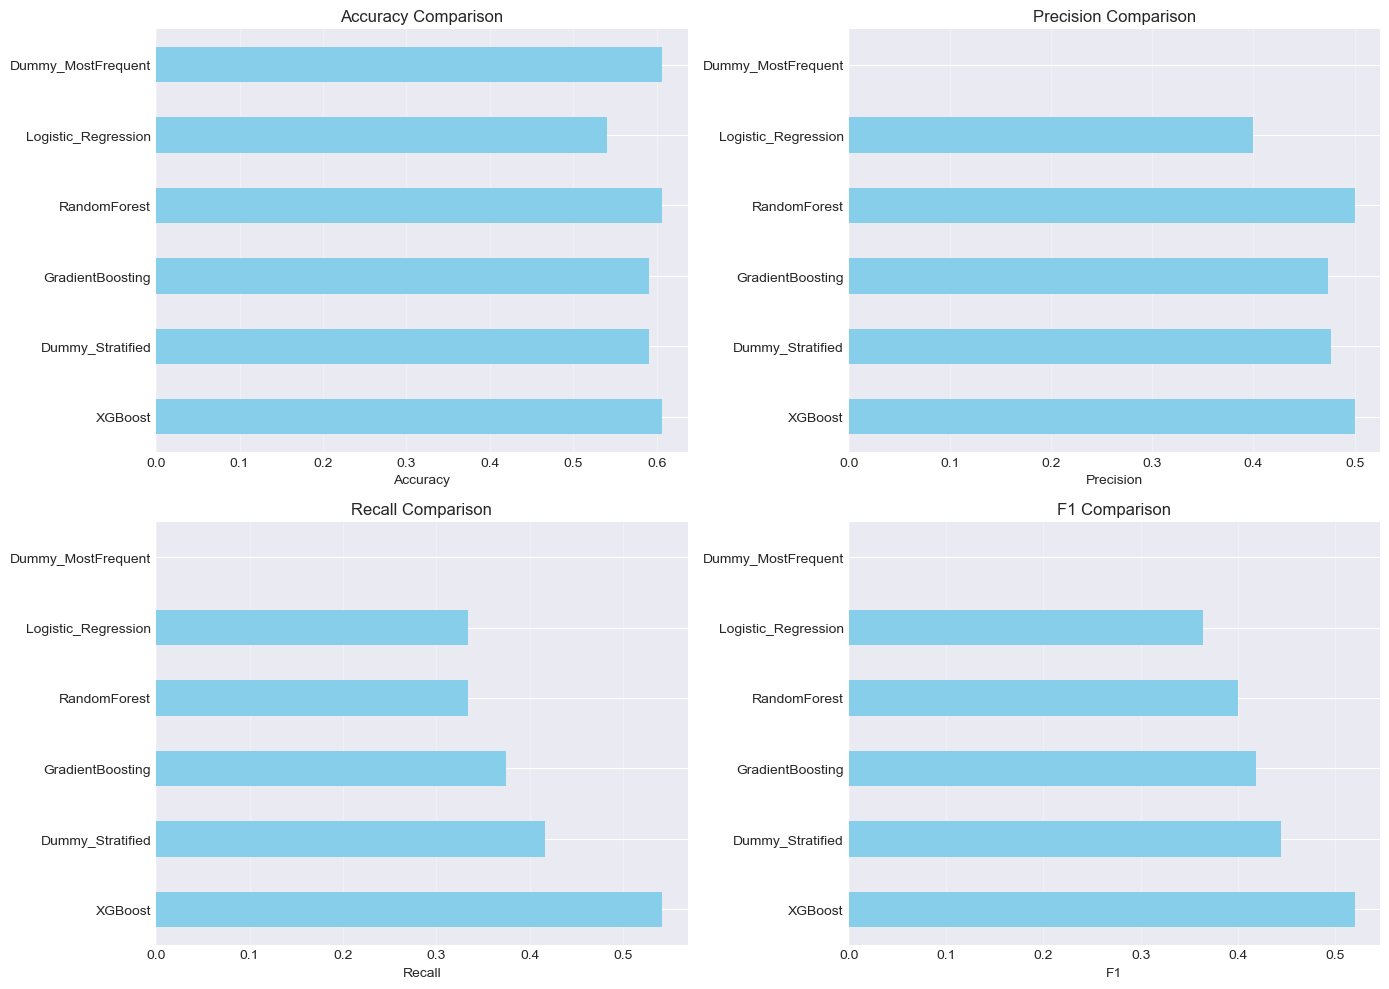


✓ Best model (by F1): XGBoost (F1=0.520)


In [18]:
# Combine all results
all_results = {**baseline_results, **tree_results}

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df[['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']]
comparison_df = comparison_df.sort_values('test_f1', ascending=False)

print("Model Comparison (sorted by F1 score):")
print(comparison_df.round(3))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']
for ax, metric in zip(axes.flat, metrics_to_plot):
    comparison_df[metric].plot(kind='barh', ax=ax, color='skyblue')
    ax.set_xlabel(metric.replace('test_', '').replace('_', ' ').title())
    ax.set_title(f'{metric.replace("test_", "").replace("_", " ").title()} Comparison')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✓ Best model (by F1): {comparison_df.index[0]} (F1={comparison_df['test_f1'].iloc[0]:.3f})")

## 10. Hyperparameter Tuning with Optuna

**Optimize best performing model (XGBoost)**

In [19]:
def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    """
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 3.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    # Train model
    model = XGBClassifier(**params)
    model.fit(X_train_balanced, y_train_balanced)
    
    # Evaluate on test set (optimize for F1 score)
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    
    return f1

print("Starting Optuna hyperparameter optimization...\n")
print("This may take a few minutes...\n")

# Create Optuna study
study = optuna.create_study(
    direction='maximize',
    study_name='xgboost_hyperparameter_tuning',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# End previous run if active
if mlflow.active_run():
    mlflow.end_run()

# Run optimization with MLflow tracking
with mlflow.start_run(run_name="XGBoost_Optuna_Tuning"):
    mlflow.log_param("optimization_method", "optuna")
    mlflow.log_param("n_trials", 30)
    mlflow.log_param("optimization_metric", "f1_score")
    
    # Run optimization
    study.optimize(objective, n_trials=30, show_progress_bar=True)
    
    # Log best results
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_test_f1", study.best_value)
    
    print(f"\n✓ Optimization complete")
    print(f"  Best F1 score: {study.best_value:.4f}")
    print(f"  Best parameters:")
    for param, value in study.best_params.items():
        print(f"    {param}: {value}")
    
    # Train final model with best parameters
    print(f"\nTraining final model with best parameters...")
    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X_train_balanced, y_train_balanced)
    
    # Log best model
    mlflow.sklearn.log_model(best_model, "best_model")
    
    # Comprehensive evaluation
    best_metrics = evaluate_model(
        best_model, X_train_balanced, X_test_scaled, y_train_balanced, y_test,
        "XGBoost_Optimized", log_artifacts=True
    )

print("\n✓ Best model trained and logged to MLflow")

[I 2025-12-12 12:45:34,594] A new study created in memory with name: xgboost_hyperparameter_tuning


Starting Optuna hyperparameter optimization...

This may take a few minutes...



Best trial: 0. Best value: 0.52:   3%|████▌                                                                                                                                  | 1/30 [00:00<00:03,  9.19it/s]

[I 2025-12-12 12:45:34,723] Trial 0 finished with value: 0.52 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'min_child_weight': 5, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'scale_pos_weight': 2.73235229154987}. Best is trial 0 with value: 0.52.


Best trial: 0. Best value: 0.52:   7%|█████████                                                                                                                              | 2/30 [00:00<00:04,  6.59it/s]

[I 2025-12-12 12:45:34,905] Trial 1 finished with value: 0.45454545454545453 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.010725209743171997, 'min_child_weight': 7, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'scale_pos_weight': 1.3668090197068676}. Best is trial 0 with value: 0.52.


Best trial: 2. Best value: 0.541667:  10%|█████████████                                                                                                                      | 3/30 [00:00<00:03,  7.54it/s]

[I 2025-12-12 12:45:35,015] Trial 2 finished with value: 0.5416666666666666 and parameters: {'n_estimators': 126, 'max_depth': 7, 'learning_rate': 0.04345454109729477, 'min_child_weight': 3, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'gamma': 1.4607232426760908, 'scale_pos_weight': 1.7327236865873834}. Best is trial 2 with value: 0.5416666666666666.
[I 2025-12-12 12:45:35,100] Trial 3 finished with value: 0.42857142857142855 and parameters: {'n_estimators': 164, 'max_depth': 9, 'learning_rate': 0.019721610970574007, 'min_child_weight': 4, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'gamma': 3.0377242595071916, 'scale_pos_weight': 1.341048247374583}. Best is trial 2 with value: 0.5416666666666666.


Best trial: 2. Best value: 0.541667:  17%|█████████████████████▊                                                                                                             | 5/30 [00:00<00:02, 11.09it/s]

[I 2025-12-12 12:45:35,131] Trial 4 finished with value: 0.46153846153846156 and parameters: {'n_estimators': 66, 'max_depth': 10, 'learning_rate': 0.26690431824362526, 'min_child_weight': 6, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'gamma': 3.4211651325607844, 'scale_pos_weight': 1.8803049874792026}. Best is trial 2 with value: 0.5416666666666666.
[I 2025-12-12 12:45:35,188] Trial 5 finished with value: 0.5 and parameters: {'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.011240768803005551, 'min_child_weight': 7, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'gamma': 1.5585553804470549, 'scale_pos_weight': 2.0401360423556216}. Best is trial 2 with value: 0.5416666666666666.


Best trial: 6. Best value: 0.571429:  23%|██████████████████████████████▌                                                                                                    | 7/30 [00:00<00:01, 13.51it/s]

[I 2025-12-12 12:45:35,239] Trial 6 finished with value: 0.5714285714285714 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.2705166881899928, 'min_child_weight': 6, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'gamma': 2.9894998940554256, 'scale_pos_weight': 2.8437484700462337}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:35,287] Trial 7 finished with value: 0.43636363636363634 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.011662890273931383, 'min_child_weight': 3, 'subsample': 0.7554709158757927, 'colsample_bytree': 0.7085396127095583, 'gamma': 4.143687545759647, 'scale_pos_weight': 1.7135066533871786}. Best is trial 6 with value: 0.5714285714285714.


Best trial: 6. Best value: 0.571429:  30%|███████████████████████████████████████▎                                                                                           | 9/30 [00:00<00:01, 15.08it/s]

[I 2025-12-12 12:45:35,347] Trial 8 finished with value: 0.4186046511627907 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.016149614799999188, 'min_child_weight': 6, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'gamma': 3.861223846483287, 'scale_pos_weight': 1.3974313630683448}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:35,387] Trial 9 finished with value: 0.38095238095238093 and parameters: {'n_estimators': 51, 'max_depth': 9, 'learning_rate': 0.11069143219393454, 'min_child_weight': 6, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'scale_pos_weight': 1.2317381190502594}. Best is trial 6 with value: 0.5714285714285714.


Best trial: 6. Best value: 0.571429:  37%|███████████████████████████████████████████████▋                                                                                  | 11/30 [00:00<00:01, 16.12it/s]

[I 2025-12-12 12:45:35,456] Trial 10 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 268, 'max_depth': 3, 'learning_rate': 0.27047297227177763, 'min_child_weight': 1, 'subsample': 0.9935496864584779, 'colsample_bytree': 0.9630659181130072, 'gamma': 4.798853729727099, 'scale_pos_weight': 2.9535357132894617}. Best is trial 6 with value: 0.5714285714285714.


Best trial: 6. Best value: 0.571429:  37%|███████████████████████████████████████████████▋                                                                                  | 11/30 [00:00<00:01, 16.12it/s]

[I 2025-12-12 12:45:35,577] Trial 11 finished with value: 0.5098039215686274 and parameters: {'n_estimators': 212, 'max_depth': 5, 'learning_rate': 0.03804350896934408, 'min_child_weight': 2, 'subsample': 0.8455839456760823, 'colsample_bytree': 0.792283845537413, 'gamma': 2.3635700332897427, 'scale_pos_weight': 2.3783175148652647}. Best is trial 6 with value: 0.5714285714285714.


Best trial: 6. Best value: 0.571429:  43%|████████████████████████████████████████████████████████▎                                                                         | 13/30 [00:01<00:01, 12.85it/s]

[I 2025-12-12 12:45:35,673] Trial 12 finished with value: 0.5517241379310345 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.049080392462631475, 'min_child_weight': 4, 'subsample': 0.9760225759970028, 'colsample_bytree': 0.8963828925472875, 'gamma': 2.4626883838430658, 'scale_pos_weight': 2.3053624004499618}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:35,762] Trial 13 finished with value: 0.5245901639344263 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.07664196967450192, 'min_child_weight': 4, 'subsample': 0.9956333540318513, 'colsample_bytree': 0.907374263836471, 'gamma': 2.6073009135279253, 'scale_pos_weight': 2.5096113595161245}. Best is trial 6 with value: 0.5714285714285714.


Best trial: 6. Best value: 0.571429:  50%|█████████████████████████████████████████████████████████████████                                                                 | 15/30 [00:01<00:01, 10.15it/s]

[I 2025-12-12 12:45:35,954] Trial 14 finished with value: 0.5614035087719298 and parameters: {'n_estimators': 231, 'max_depth': 3, 'learning_rate': 0.02892070398572207, 'min_child_weight': 5, 'subsample': 0.9208078013891599, 'colsample_bytree': 0.8915280998737625, 'gamma': 2.31057379200564, 'scale_pos_weight': 2.3094899565546507}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:36,093] Trial 15 finished with value: 0.5396825396825397 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.030041618893516166, 'min_child_weight': 5, 'subsample': 0.8964612764719793, 'colsample_bytree': 0.8161250100672572, 'gamma': 3.210199461376242, 'scale_pos_weight': 2.938539704097435}. Best is trial 6 with value: 0.5714285714285714.


Best trial: 6. Best value: 0.571429:  63%|██████████████████████████████████████████████████████████████████████████████████▎                                               | 19/30 [00:01<00:01, 10.64it/s]

[I 2025-12-12 12:45:36,166] Trial 16 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 201, 'max_depth': 4, 'learning_rate': 0.18445625019968084, 'min_child_weight': 5, 'subsample': 0.9394985976994268, 'colsample_bytree': 0.9389434602696806, 'gamma': 1.9981445386169006, 'scale_pos_weight': 2.6555745189150812}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:36,268] Trial 17 finished with value: 0.5245901639344263 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.024572563207403402, 'min_child_weight': 6, 'subsample': 0.884736076825001, 'colsample_bytree': 0.8386546092850229, 'gamma': 3.9947738410656726, 'scale_pos_weight': 2.1992816888392483}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:36,325] Trial 18 finished with value: 0.5666666666666667 and parameters: {'n_estimators': 172, 'max_depth': 3, 'learning_rate': 0.07810114785523485, 'min_child_weight': 7, 'subsample': 0.800412889447534, 'colsample

Best trial: 6. Best value: 0.571429:  70%|███████████████████████████████████████████████████████████████████████████████████████████                                       | 21/30 [00:01<00:00, 11.90it/s]

[I 2025-12-12 12:45:36,386] Trial 19 finished with value: 0.5245901639344263 and parameters: {'n_estimators': 157, 'max_depth': 5, 'learning_rate': 0.07097783577505475, 'min_child_weight': 7, 'subsample': 0.8218201068168658, 'colsample_bytree': 0.73964158693172, 'gamma': 4.878515159689263, 'scale_pos_weight': 2.758673108890447}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:36,448] Trial 20 finished with value: 0.5161290322580645 and parameters: {'n_estimators': 181, 'max_depth': 4, 'learning_rate': 0.16522729299476807, 'min_child_weight': 7, 'subsample': 0.7727431143998708, 'colsample_bytree': 0.764088169035724, 'gamma': 4.304903006591545, 'scale_pos_weight': 2.507805263248452}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:36,553] Trial 21 finished with value: 0.5283018867924528 and parameters: {'n_estimators': 183, 'max_depth': 3, 'learning_rate': 0.07559862179262622, 'min_child_weight': 5, 'subsample': 0.9466793756197365, 'colsample_bytre

Best trial: 23. Best value: 0.596491:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 25/30 [00:02<00:00, 11.18it/s]

[I 2025-12-12 12:45:36,648] Trial 22 finished with value: 0.5614035087719298 and parameters: {'n_estimators': 225, 'max_depth': 3, 'learning_rate': 0.031025605358426522, 'min_child_weight': 6, 'subsample': 0.8749408887636946, 'colsample_bytree': 0.8725646519101077, 'gamma': 2.947826435282221, 'scale_pos_weight': 2.2178739711539}. Best is trial 6 with value: 0.5714285714285714.
[I 2025-12-12 12:45:36,736] Trial 23 finished with value: 0.5964912280701754 and parameters: {'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.1212049710316939, 'min_child_weight': 7, 'subsample': 0.7842376138425562, 'colsample_bytree': 0.9878419455300442, 'gamma': 3.513112837334288, 'scale_pos_weight': 2.5013410383072903}. Best is trial 23 with value: 0.5964912280701754.
[I 2025-12-12 12:45:36,830] Trial 24 finished with value: 0.5263157894736842 and parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.1234853535397726, 'min_child_weight': 7, 'subsample': 0.7834605681728348, 'colsample_byt

Best trial: 23. Best value: 0.596491:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 27/30 [00:02<00:00, 12.07it/s]

[I 2025-12-12 12:45:36,878] Trial 25 finished with value: 0.5357142857142857 and parameters: {'n_estimators': 105, 'max_depth': 5, 'learning_rate': 0.18715952917056752, 'min_child_weight': 7, 'subsample': 0.7041631226721012, 'colsample_bytree': 0.956844483290207, 'gamma': 4.512176057752663, 'scale_pos_weight': 2.5234508272860663}. Best is trial 23 with value: 0.5964912280701754.
[I 2025-12-12 12:45:36,965] Trial 26 finished with value: 0.5862068965517241 and parameters: {'n_estimators': 258, 'max_depth': 3, 'learning_rate': 0.08916872078674255, 'min_child_weight': 6, 'subsample': 0.737691866387846, 'colsample_bytree': 0.7345538254990203, 'gamma': 3.534164643549821, 'scale_pos_weight': 2.998985127674988}. Best is trial 23 with value: 0.5964912280701754.
[I 2025-12-12 12:45:37,058] Trial 27 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 266, 'max_depth': 4, 'learning_rate': 0.10075746540861177, 'min_child_weight': 6, 'subsample': 0.7408939070258674, 'colsample_b

Best trial: 23. Best value: 0.596491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.41it/s]
2025/12/12 12:45:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[I 2025-12-12 12:45:37,155] Trial 28 finished with value: 0.5172413793103449 and parameters: {'n_estimators': 243, 'max_depth': 6, 'learning_rate': 0.15634146345768693, 'min_child_weight': 6, 'subsample': 0.6532912859582701, 'colsample_bytree': 0.9751874149132673, 'gamma': 2.774207665608418, 'scale_pos_weight': 2.814607946955267}. Best is trial 23 with value: 0.5964912280701754.
[I 2025-12-12 12:45:37,244] Trial 29 finished with value: 0.5357142857142857 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learning_rate': 0.22575005257914607, 'min_child_weight': 5, 'subsample': 0.678960093852698, 'colsample_bytree': 0.8470060800098997, 'gamma': 3.339040583370426, 'scale_pos_weight': 2.7470990088314267}. Best is trial 23 with value: 0.5964912280701754.

✓ Optimization complete
  Best F1 score: 0.5965
  Best parameters:
    n_estimators: 255
    max_depth: 3
    learning_rate: 0.1212049710316939
    min_child_weight: 7
    subsample: 0.7842376138425562
    colsample_bytree: 0.987841945

## 11. Model Explainability with SHAP

**Understand what drives predictions**

Generating SHAP explanations...

✓ SHAP values calculated for 61 test samples



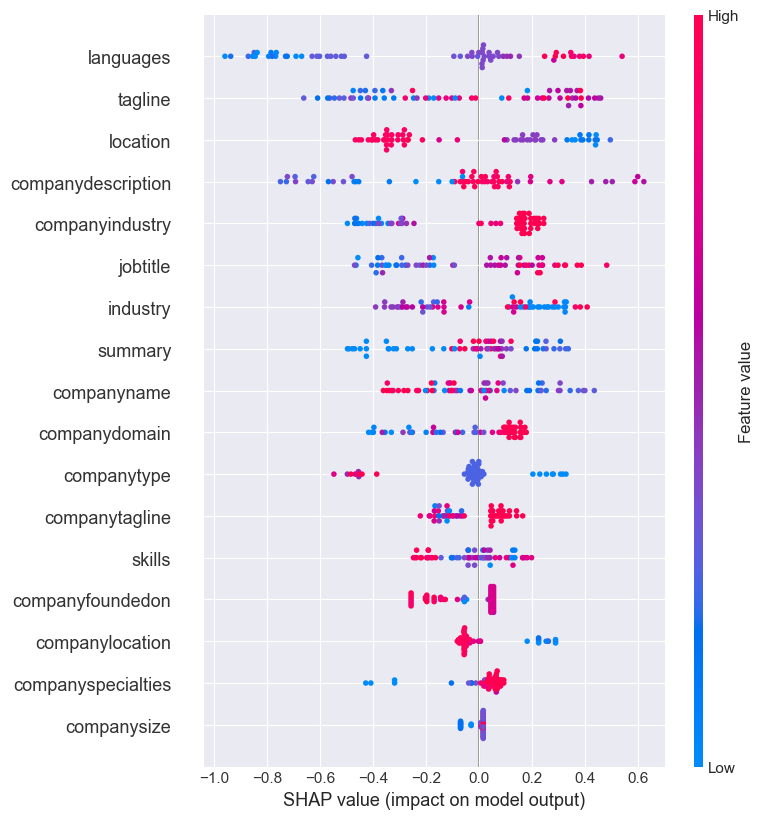

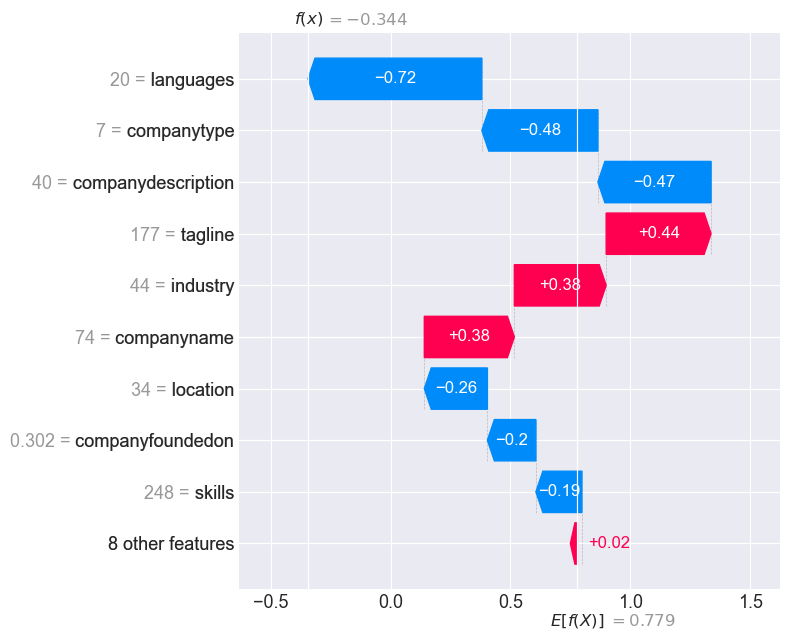


✓ SHAP explanations generated and logged to MLflow


In [20]:
print("Generating SHAP explanations...\n")

# Create SHAP explainer for best model
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set (sample for speed)
sample_size = min(100, len(X_test_scaled))
X_test_sample = X_test_scaled.sample(n=sample_size, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

print(f"✓ SHAP values calculated for {sample_size} test samples\n")

# End previous run if active (start new for SHAP artifacts)
if mlflow.active_run():
    mlflow.end_run()

with mlflow.start_run(run_name="SHAP_Explainability"):
    mlflow.log_param("model_explained", "XGBoost_Optimized")
    mlflow.log_param("shap_sample_size", sample_size)
    
    # Summary plot (feature importance)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.tight_layout()
    plt.savefig('/tmp/shap_summary.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/shap_summary.png', 'explainability')
    plt.show()
    
    # Waterfall plot for first prediction
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_test_sample.iloc[0],
        feature_names=X_test_sample.columns.tolist()
    ), show=False)
    plt.tight_layout()
    plt.savefig('/tmp/shap_waterfall.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('/tmp/shap_waterfall.png', 'explainability')
    plt.show()
    
    print("\n✓ SHAP explanations generated and logged to MLflow")

## 12. Model Selection & Registration

**Register best model in MLflow Model Registry**

In [21]:
# Query MLflow for best model
experiment = mlflow.get_experiment_by_name("linkedin-lead-scoring")
runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Filter for model training runs
model_runs = runs_df[
    runs_df['tags.mlflow.runName'].str.contains('tree_|baseline_|Optuna', na=False)
]

# Sort by F1 score
best_run = model_runs.sort_values('metrics.test_f1', ascending=False).iloc[0]

print("Best Model Selection:")
print(f"  Model: {best_run['tags.mlflow.runName']}")
print(f"  Run ID: {best_run['run_id']}")
print(f"  Test F1: {best_run['metrics.test_f1']:.3f}")
print(f"  Test Precision: {best_run['metrics.test_precision']:.3f}")
print(f"  Test Recall: {best_run['metrics.test_recall']:.3f}")
print(f"  Test ROC-AUC: {best_run['metrics.test_roc_auc']:.3f}")

# Register model
model_uri = f"runs:/{best_run['run_id']}/model"
model_name = "linkedin-lead-scorer"

try:
    model_version = mlflow.register_model(model_uri, model_name)
    
    print(f"\n✓ Model registered: '{model_name}' version {model_version.version}")
    
    # Transition to Production (optional - can also do manually in UI)
    # client = mlflow.tracking.MlflowClient()
    # client.transition_model_version_stage(
    #     name=model_name,
    #     version=model_version.version,
    #     stage="Production"
    # )
    # print(f"✓ Model transitioned to Production stage")
    
except Exception as e:
    print(f"\nℹ️  Model registration note: {e}")
    print("   (Model may already be registered - check MLflow UI)")

print(f"\n✓ Model selection complete")
print(f"\nView in MLflow UI: http://localhost:5000")
print(f"  → Navigate to 'Models' tab to see registered model")

Best Model Selection:
  Model: XGBoost_Optuna_Tuning
  Run ID: 03c1b76a8dfc4d2399bdf4715996079d
  Test F1: 0.556
  Test Precision: 0.500
  Test Recall: 0.625
  Test ROC-AUC: 0.591

ℹ️  Model registration note: Unable to find a logged_model with artifact_path model under run 03c1b76a8dfc4d2399bdf4715996079d
   (Model may already be registered - check MLflow UI)

✓ Model selection complete

View in MLflow UI: http://localhost:5000
  → Navigate to 'Models' tab to see registered model


Successfully registered model 'linkedin-lead-scorer'.


## 13. Summary & Next Steps

In [22]:
print("="*60)
print("MODEL TRAINING SUMMARY")
print("="*60)
print(f"\nDataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Train: {len(X_train):,} samples")
print(f"  Test:  {len(X_test):,} samples")
print(f"\nModels trained: {len(all_results)}")
print(f"  Baseline: {len(baseline_results)}")
print(f"  Tree-based: {len(tree_results)}")
print(f"  Optimized: 1 (XGBoost with Optuna)")
print(f"\nBest Model:")
print(f"  Name: {best_run['tags.mlflow.runName']}")
print(f"  Test F1: {best_run['metrics.test_f1']:.3f}")
print(f"  Test Precision: {best_run['metrics.test_precision']:.3f}")
print(f"  Test Recall: {best_run['metrics.test_recall']:.3f}")
print(f"  Test ROC-AUC: {best_run['metrics.test_roc_auc']:.3f}")
print(f"\nMLflow:")
print(f"  Experiment: linkedin-lead-scoring")
print(f"  Registered model: {model_name}")
print(f"  MLflow UI: http://localhost:5000")
print(f"\n" + "="*60)
print("✓ Model training complete!")
print("Next steps:")
print("  1. Review model performance in MLflow UI")
print("  2. Analyze SHAP explanations for insights")
print("  3. Consider feature engineering enhancements")
print("  4. Deploy model via FastAPI endpoint")
print("="*60)

MODEL TRAINING SUMMARY

Dataset:
  Total samples: 303
  Train: 242 samples
  Test:  61 samples

Models trained: 6
  Baseline: 3
  Tree-based: 3
  Optimized: 1 (XGBoost with Optuna)

Best Model:
  Name: XGBoost_Optuna_Tuning
  Test F1: 0.556
  Test Precision: 0.500
  Test Recall: 0.625
  Test ROC-AUC: 0.591

MLflow:
  Experiment: linkedin-lead-scoring
  Registered model: linkedin-lead-scorer
  MLflow UI: http://localhost:5000

✓ Model training complete!
Next steps:
  1. Review model performance in MLflow UI
  2. Analyze SHAP explanations for insights
  3. Consider feature engineering enhancements
  4. Deploy model via FastAPI endpoint


## 14. Clean Up

In [ ]:
# End MLflow run
if mlflow.active_run():
    mlflow.end_run()

print("✓ All MLflow runs ended")
print(f"\nView all results at: http://localhost:5000")